---
# Lecture notes - Logistic regression
---

This is the lecture note for **logistic regression**

<p class = "alert alert-info" role="alert"><b>Note</b> that this lecture note gives a brief introduction to logistic regression. I encourage you to read further about logistic regression. </p>

Read more:

- [Logistic regression wikipedia](https://en.wikipedia.org/wiki/Logistic_regression)
- [ISLRv2 pp 129-141](https://www.statlearning.com/)
- [Precision, accuracy, recall, F-score](https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/)
- [Precision and recall wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)
---


In [69]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 

## EDA


In [70]:
df = pd.read_csv("../assets/default.csv")

df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


In [72]:
df.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33516.981876
std,483.714985,13336.639563
min,0.000000,771.967729
25%,481.731105,21340.462903
50%,823.636973,34552.644802
75%,1166.308386,43807.729272
max,2654.322576,73554.233495


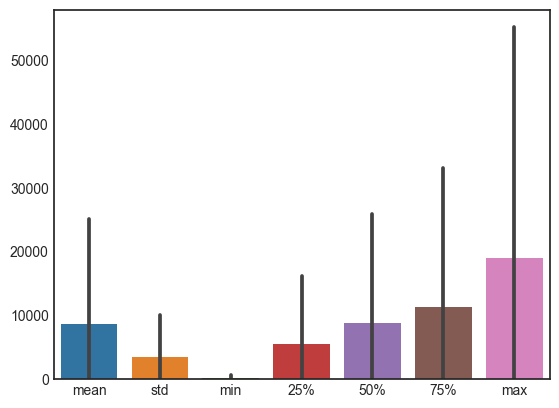

In [163]:
sns.barplot(df.describe().T.drop("count", axis = 1));

In [74]:
df["default"].value_counts() # unbalanced dataset, not 50/50 representation

No     9667
Yes     333
Name: default, dtype: int64

In [75]:
df["student"].value_counts()

No     7056
Yes    2944
Name: student, dtype: int64

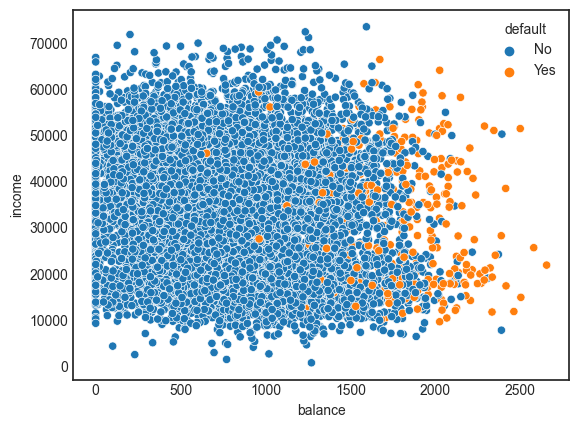

In [76]:
sns.scatterplot(data=df, x="balance", y = "income", hue = "default");
# we see that the data is very closely packed, which will be hard to train a good model for finding default 
# also the data is highly imbalanced

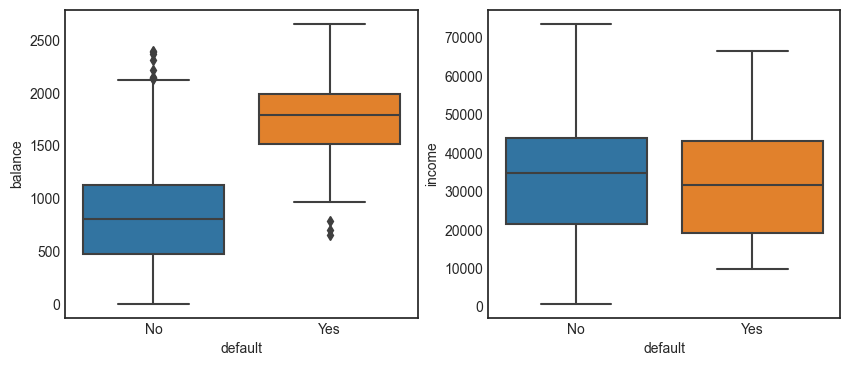

In [77]:
fig, ax = plt.subplots(1, 2, dpi=100, figsize = (10,4))

for axe, col in zip(ax, ["balance", "income"]):
    sns.boxplot(data=df, x="default", y=col, ax=axe)


## One-hot encoding

The features default and student are categorical. In order to make calculations on those variables, we need to represent them using dummy variables. This is called one-hot encoding.   

In [78]:
df = pd.get_dummies(df, columns = ["default", "student"], drop_first=True)

df.head()

,balance,income,default_Yes,student_Yes
0,729.526495,44361.625074,0,0
1,817.180407,12106.134700,0,1
2,1073.549164,31767.138947,0,0
3,529.250605,35704.493935,0,0
4,785.655883,38463.495879,0,0


---
## Logistic function 

The response variable that we want to predict is qualitative or categorical. We want to model the conditional probability of default given the balance

$p(X) = P(\textnormal{default = yes|balance}) = P(Y=1|X)$

For example p > 0.5, means we predict a certain person will default with higher than 0.5 probability. Must model $p(X)$ s.t. $p(X)\in[0,1]$. We begin with 

$p(X) = \frac{e^{\beta_0+\beta_1X}}{1+e^{\beta_0+\beta_1X}}$

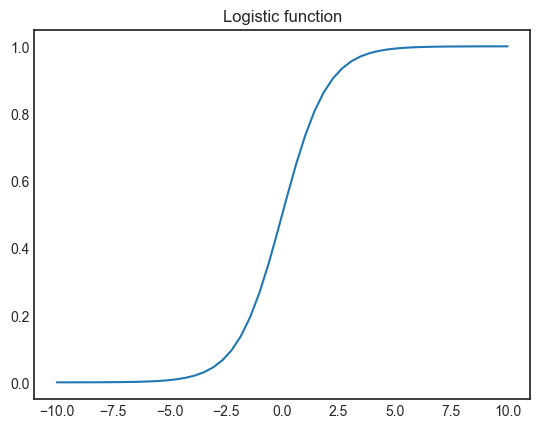

In [79]:
logistic_function = lambda x: np.exp(x)/(1+np.exp(x)) # beta_0 = 0, beta_1 = 1

x = np.linspace(-10, 10)
plt.plot(x, logistic_function(x))
plt.title("Logistic function"); 
# values are constrained to 0 and 1, S-shaped curve

## Logistic Regression

### Odds

A convenient way to talk about how a variable relates to another one is to use odds ratio, which is a statistics that can vary from 0 to $\infty$. The odds of a default vs not a default is given by this fraction of probability: 

$$\frac{p(X)}{1-p(X)} = e^{\beta_0+\beta_1X}$$

For example on average 3 of 10 gets a default is given by $0.3/0.7 = 3/7$.

We take logarithm of both sides and obtain the log odds or logit

$$\log{\left(\frac{p(X)}{1-p(X)} \right)} = \beta_0 + \beta_1X$$

This model is linear in $X$ and the parameters $\beta_0, \beta_1$ are chosen to maximize the likelihood function

$$l(\beta_0, \beta_1) = \prod_{y_i = 1}p(x_i)\prod_{y_j=0}(1-p(x_j))$$

In practice the log likelihood function is maximized using an optimization alogrithm such as batch gradient descent, mini-batch gradient descent or stochastic gradient descent.  

In [80]:
from sklearn.model_selection import train_test_split

X, y = df.drop("default_Yes", axis=1), df["default_Yes"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train.shape, X_test.shape

((6700, 3), (3300, 3))

In [81]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
scaler = MinMaxScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

scaled_X_train.mean(), scaled_X_train.std(), scaled_X_test.mean(), scaled_X_test.std()

(0.35362610657461696,
 0.3110663167041688,
 0.3517552693096858,
 0.308636912951103)

In [82]:
scaled_X_train[7:9] # can see how student_Yes was scaled in the last column

array([[0.5038247 , 0.55999334, 0.        ],
       [0.24135708, 0.39109338, 1.        ]])

In [83]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty=None)

model.fit(scaled_X_train, y_train)

model.coef_, model.intercept_
# high balance -> adds much to prob default
# income does not seem correlated
# being a student -> lowers risk of default

(array([[15.78304937,  0.03724382, -0.63436536]]), array([-11.14601856]))

Creating test data samples

In [92]:
test_sample = pd.DataFrame({
    "balance": [1500, 1500], 
    "income": [40000, 40000], 
    "student_Yes": [1, 0]
    })

test_sample # only difference is that one is student and the other is not

,balance,income,student_Yes
0,1500,40000,1
1,1500,40000,0


In [93]:
scaled_test_sample = scaler.transform(test_sample)

# first column is -1 label i.e. not default, second column is label 1 i.e. default

model.predict_proba(scaled_test_sample) # we see that being student decreases the chance of getting default 

array([[0.94485459, 0.05514541],
       [0.90084886, 0.09915114]])

In [86]:
y_pred_probability = model.predict_proba(scaled_X_test)

y_pred_probability[:5]

array([[9.30448366e-01, 6.95516343e-02],
       [9.98551332e-01, 1.44866830e-03],
       [9.99985411e-01, 1.45886306e-05],
       [9.99971177e-01, 2.88228438e-05],
       [9.54574522e-01, 4.54254781e-02]])

---

## Evaluation metrics for classification

Confusion matrix

||Pos prediction|Neg prediction|
|---|---|---|
|Pos class|TP|FN|
|Neg class|FP|TN|

- accuracy - ratio of correct predictions to all predictions
    - bad measure when, dataset class is imbalanced, e.g. a fraud model that always predicts non fraudulent could achieve accuracy of close to 1 without having any predictive power. 
- precision - number of positive class predictions that belong to positive class
    - good measure when FP is allowed to be higher e.g. email spam classification 
- recall - sensitivity - number of positive class predictions out of all positive examples 
    - good measure when there is high cost with FN e.g. sick patient of a contageous disease such as Covid-19 quick test
- $F_1$ score - harmonic mean between precision and recall 
    - seeks a balance between precision, recall and uneven class distributions

$ acc = \frac{TP+TN}{Total} $

$ prec = \frac{TP}{TP+FP}$

$ rec = \frac{TP}{TP+FN}$

$ F_1 = 2\frac{prec\cdot recall}{prec + rec}$

In [94]:
y_pred = model.predict(scaled_X_test)

y_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=uint8)

In [132]:
threshold = 0.5 # change threshold manually based on application needs - talk to domain expert

y_pred_probability = model.predict_proba(scaled_X_test)
y_pred_manual = (y_pred_probability > threshold)[:,1] * 1 # manual threshold for probabilities

y_pred_manual

array([0, 0, 0, ..., 0, 1, 0])

In [108]:
y_pred.sum(), y_pred_manual.sum() # can see that setting threshold = 0.5 gives same result, so default setting of model.predict is 0.5

(46, 46)

In [124]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report

acc = accuracy_score(y_test, y_pred)
# note that the accuracy is very high, which is because of the accuracy paradox as the data is highly imbalanced. 
# this means that we could make a model that always classifies negative on default, and achieve very high accuracy
print(f"Accuracy: {acc:.3f}")

Accuracy: 0.973


In [133]:
cm = confusion_matrix(y_test, y_pred, labels = model.classes_)

cm

#   0  1
# 0 TN FP
# 1 FN TP

array([[3177,   13],
       [  77,   33]], dtype=int64)

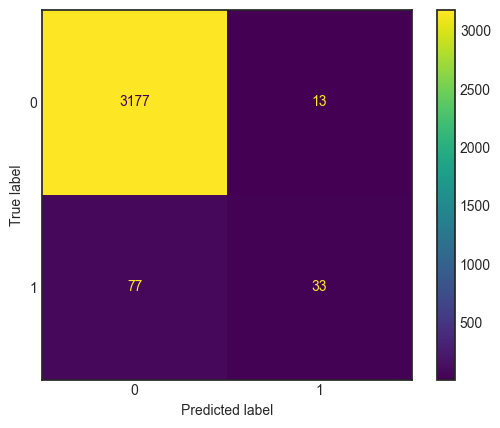

In [134]:
disp = ConfusionMatrixDisplay(cm, display_labels = model.classes_)

disp.plot();

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      3190
           1       0.29      0.68      0.41       110

    accuracy                           0.93      3300
   macro avg       0.64      0.81      0.69      3300
weighted avg       0.97      0.93      0.95      3300



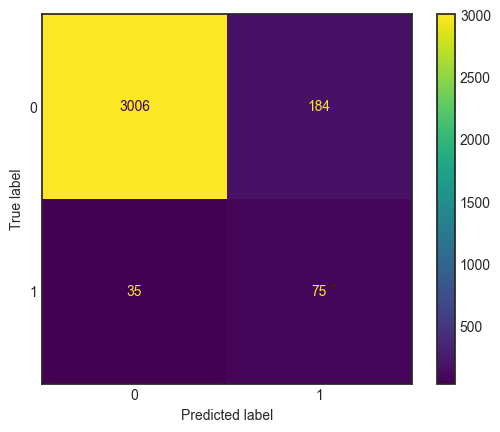

In [159]:
threshold = 0.1

y_pred_probability = model.predict_proba(scaled_X_test)
y_pred_manual = (y_pred_probability > threshold)[:,1] * 1

cm = confusion_matrix(y_test, y_pred_manual, labels = model.classes_)

disp = ConfusionMatrixDisplay(cm, display_labels = model.classes_)

disp.plot();
print(classification_report(y_test, y_pred_manual))

In [116]:
# manually evaluating

TP = 33
TN = 3177
FP = 13
FN = 77

accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)
f1 = 2 * recall * precision / (recall + precision)

accuracy, recall, precision, f1

(0.9727272727272728, 0.3, 0.717391304347826, 0.4230769230769231)

In [89]:
print(classification_report(y_test, y_pred))
# recall and f1 score is very bad here for label 1 indicating that the model having a lot of FN, 
# which means it tends to classify someone that should default as not default
# this can also be seen in the confusion matrix

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3190
           1       0.72      0.30      0.42       110

    accuracy                           0.97      3300
   macro avg       0.85      0.65      0.70      3300
weighted avg       0.97      0.97      0.97      3300



---

Kokchun Giang

[LinkedIn][linkedIn_kokchun]

[GitHub portfolio][github_portfolio]

[linkedIn_kokchun]: https://www.linkedin.com/in/kokchungiang/
[github_portfolio]: https://github.com/kokchun/Portfolio-Kokchun-Giang

---
